<a href="https://colab.research.google.com/github/Saul-Ochoa/Time-Series/blob/main/LGBMREGRESSOR/LightGBM_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LightGBM Regression**

In [22]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import zipfile
from sklearn.model_selection import train_test_split
# Download latest version
path = kagglehub.dataset_download("arunjangir245/boston-housing-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arunjangir245/boston-housing-dataset/versions/2


In [23]:
zip_path='/content/archive (21).zip'
# Abrir el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as z:
    # Listar los archivos contenidos en el ZIP
    print("Archivos en el ZIP:", z.namelist())

    # Seleccionar el archivo CSV (ajusta el nombre según el contenido del ZIP)
    csv_file_name = z.namelist()[0]  # Selecciona el primer archivo (o el específico si lo sabes)

    # Leer el archivo CSV directamente desde el ZIP
    with z.open(csv_file_name) as f:
        df = pd.read_csv(f, sep=',')  # Ajusta 'sep' si el delimitador no es una coma
        print(df.head())

Archivos en el ZIP: ['BostonHousing.csv']
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio       b  lstat  medv
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7  396.90   5.33  36.2


In [24]:
# Features (X) and target (y)
X = df.drop('medv', axis=1)  # All columns except 'medv'
y = df['medv']

In [25]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## **LGB Train**

In [26]:
params={
    'task':'train',
    'boosting':'gbdt',
    'objective':'regression',
    'metric':{'l2','l1'},
    'learning_rate':0.01,
    'verbose':-1
}

lgb_train=lgb.Dataset(x_train,y_train)
lgb_eval=lgb.Dataset(x_test,y_test,reference=lgb_train)

# Using the early_stopping callback for early stopping
model=lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=30)] # Pass early stopping as a callback
)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.3093	valid_0's l2: 23.6191


In [27]:
y_pred=model.predict(x_test)
mse=np.mean((y_test-y_pred)**2)
rmse=np.sqrt(mse)
#Instead of model.score use r2_score from sklearn.metrics
r2=r2_score(y_test,y_pred) #Calculate R-squared using the actual and predicted values
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MSE: 23.619117708912462
RMSE: 4.859950381322062
R2: 0.6779230977723304


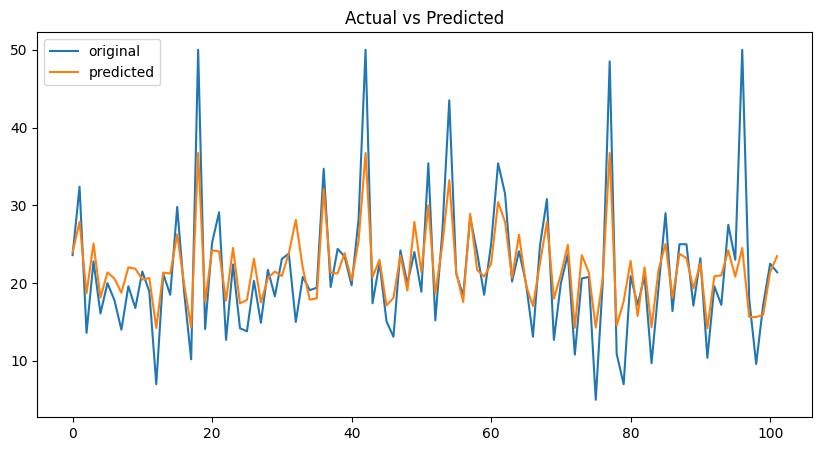

In [28]:
x_ax=range(len(y_test))
plt.figure(figsize=(10,5))
plt.plot(x_ax,y_test,label='original')
plt.plot(x_ax,y_pred,label='predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

## **Hiperparametros**

In [35]:
# Crear datasets para LightGBM
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# Espacio de hiperparámetros para búsqueda aleatoria
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'metric': ['l2', 'l1'],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': np.random.randint(20, 100, 10),  # Asegura enteros
    'max_depth': [-1, 5, 10, 15],
    'feature_fraction': np.linspace(0.6, 1.0, 5),
    'bagging_fraction': np.linspace(0.6, 1.0, 5),
    'bagging_freq': [0, 5, 10],
    'verbose': [-1],
    'seed': [42]
}

# Función para búsqueda aleatoria
def random_search(param_grid, num_iter=10):
    random_params = []
    for _ in range(num_iter):
        params = {key: np.random.choice(values) if isinstance(values, list) else np.random.uniform(min(values), max(values))
                  for key, values in param_grid.items()}
        if 'num_leaves' in params:
            params['num_leaves'] = int(params['num_leaves'])  # Asegurar entero
        random_params.append(params)
    return random_params

# Obtener una lista de combinaciones aleatorias
random_params_list = random_search(param_grid, num_iter=20)

best_model = None
best_params = None
best_mse = float('inf')

# Evaluar cada conjunto de parámetros
for params in random_params_list:
    print(f"Evaluando con parámetros: {params}")

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_eval],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),  # Early stopping como callback
            lgb.log_evaluation(period=100)          # Logs cada 100 iteraciones
        ]
    )

    # Predicciones
    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE: {mse:.4f}")

    # Guardar el mejor modelo
    if mse < best_mse:
        best_mse = mse
        best_model = model
        best_params = params

print(f"\nMejores parámetros: {best_params}")
print(f"Mejor MSE: {best_mse:.4f}")


Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.1, 'num_leaves': 35, 'max_depth': 15, 'feature_fraction': 0.7667432233701394, 'bagging_fraction': 0.8567603835568587, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l1: 2.16441
Early stopping, best iteration is:
[120]	valid_0's l1: 2.14798
MSE: 10.3077
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.05, 'num_leaves': 48, 'max_depth': 15, 'feature_fraction': 0.6589774138870342, 'bagging_fraction': 0.7339972703341653, 'bagging_freq': 0, 'verbose': -1, 'seed': 42}
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l1: 2.13764
[200]	valid_0's l1: 2.02487
Early stopping, best iteration is:
[199]	valid_0's l1: 2.02287
MSE: 9.5141
Evaluando con parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	valid_0's l2: 15.5041
[300]	valid_0's l2: 11.8988
[400]	valid_0's l2: 11.7619
[500]	valid_0's l2: 9.96661
[600]	valid_0's l2: 10.1077
[700]	valid_0's l2: 8.86675
[800]	valid_0's l2: 8.13792
[900]	valid_0's l2: 7.72781
[1000]	valid_0's l2: 7.55212
MSE: 7.5521
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l2', 'learning_rate': 0.01, 'num_leaves': 43, 'max_depth': 10, 'feature_fraction': 0.7690929926180263, 'bagging_fraction': 0.7915032364296666, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l2: 24.6513
[200]	valid_0's l2: 15.5631
[300]	valid_0's l2: 13.0922
[400]	valid_0's l2: 12.0708
[500]	valid_0's l2: 11.4852
[600]	valid_0's l2: 11.0654
[700]	valid_0's l2: 10.7771
[800]	valid_0's l2: 10.4321
[900]	valid_0's l2: 10.0648
[1000]	valid_0's l2: 9.84216
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 9.84216
MSE: 9.8422
Evaluando con parámetros:

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[300]	valid_0's l1: 2.69625
[400]	valid_0's l1: 2.66443
[500]	valid_0's l1: 2.35891
[600]	valid_0's l1: 2.28633
[700]	valid_0's l1: 2.17449
[800]	valid_0's l1: 2.14832
[900]	valid_0's l1: 2.10593
[1000]	valid_0's l1: 2.09333
MSE: 9.4830
Evaluando con parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric': 'l2', 'learning_rate': 0.05, 'num_leaves': 55, 'max_depth': -1, 'feature_fraction': 0.8741238694435098, 'bagging_fraction': 0.9791952311186676, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
[100]	valid_0's l2: 32.9413


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	valid_0's l2: 30.3985
[300]	valid_0's l2: 16.0988
[400]	valid_0's l2: 15.4606
[500]	valid_0's l2: 12.1678
[600]	valid_0's l2: 11.6285
[700]	valid_0's l2: 10.0132
[800]	valid_0's l2: 9.48428
[900]	valid_0's l2: 8.77447
[1000]	valid_0's l2: 8.61496
MSE: 8.6150
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.05, 'num_leaves': 32, 'max_depth': 10, 'feature_fraction': 0.8972556027176685, 'bagging_fraction': 0.9388729478180231, 'bagging_freq': 10, 'verbose': -1, 'seed': 42}
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l1: 2.14992
Early stopping, best iteration is:
[100]	valid_0's l1: 2.14992
MSE: 10.8943
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.01, 'num_leaves': 59, 'max_depth': 15, 'feature_fraction': 0.6813308249356509, 'bagging_fraction': 0.7852483543179051, 'bagging_freq': 0, 'verbose': -1, 'seed': 42}
Training un

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[300]	valid_0's l2: 16.4521
[400]	valid_0's l2: 15.5152
[500]	valid_0's l2: 12.7944
[600]	valid_0's l2: 12.0779
[700]	valid_0's l2: 10.7029
[800]	valid_0's l2: 9.43691
[900]	valid_0's l2: 8.82105
[1000]	valid_0's l2: 8.63584
MSE: 8.6358
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.01, 'num_leaves': 41, 'max_depth': 10, 'feature_fraction': 0.8799123360168686, 'bagging_fraction': 0.7152510439650286, 'bagging_freq': 10, 'verbose': -1, 'seed': 42}
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l1: 3.31005
[200]	valid_0's l1: 2.52938
[300]	valid_0's l1: 2.24961
[400]	valid_0's l1: 2.17008
Early stopping, best iteration is:
[370]	valid_0's l1: 2.1528
MSE: 12.6642
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.01, 'num_leaves': 85, 'max_depth': -1, 'feature_fraction': 0.9850292000157482, 'bagging_fraction': 0.7291238793666563, 'b

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	valid_0's l2: 15.652
[300]	valid_0's l2: 10.57
[400]	valid_0's l2: 9.92097
[500]	valid_0's l2: 9.27056
[600]	valid_0's l2: 8.32778
[700]	valid_0's l2: 7.50493
[800]	valid_0's l2: 7.18581
[900]	valid_0's l2: 6.82392
[1000]	valid_0's l2: 6.70551
MSE: 6.7055
Evaluando con parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.1, 'num_leaves': 35, 'max_depth': 10, 'feature_fraction': 0.926121545468821, 'bagging_fraction': 0.9029258257880526, 'bagging_freq': 10, 'verbose': -1, 'seed': 42}


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	valid_0's l1: 2.61224
[200]	valid_0's l1: 2.60428
[300]	valid_0's l1: 2.19939
[400]	valid_0's l1: 2.12416
[500]	valid_0's l1: 2.02225
[600]	valid_0's l1: 1.96822
[700]	valid_0's l1: 1.90911
[800]	valid_0's l1: 1.89292
[900]	valid_0's l1: 1.88547
[1000]	valid_0's l1: 1.89934
MSE: 7.0496
Evaluando con parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric': 'l2', 'learning_rate': 0.01, 'num_leaves': 62, 'max_depth': 5, 'feature_fraction': 0.6610536906556327, 'bagging_fraction': 0.987490352799508, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
[100]	valid_0's l2: 134.096


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	valid_0's l2: 155.49
[300]	valid_0's l2: 107.439
[400]	valid_0's l2: 93.7384
[500]	valid_0's l2: 72.7749
[600]	valid_0's l2: 62.8025
[700]	valid_0's l2: 44.3966
[800]	valid_0's l2: 33.8441
[900]	valid_0's l2: 27.1428
[1000]	valid_0's l2: 26.6665
MSE: 26.6665
Evaluando con parámetros: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.05, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.6582466138556297, 'bagging_fraction': 0.9294710968118669, 'bagging_freq': 0, 'verbose': -1, 'seed': 42}
Training until validation scores don't improve for 30 rounds
[100]	valid_0's l1: 2.16624
[200]	valid_0's l1: 2.05903
Early stopping, best iteration is:
[246]	valid_0's l1: 2.01809
MSE: 9.0933
Evaluando con parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.05, 'num_leaves': 33, 'max_depth': 10, 'feature_fraction': 0.6959520743251203, 'bagging_fraction': 0.9803840233902996, 'bagging_freq': 10, 'verbose': 

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	valid_0's l1: 4.30768
[200]	valid_0's l1: 4.24027
[300]	valid_0's l1: 2.73315
[400]	valid_0's l1: 2.67717
[500]	valid_0's l1: 2.3806
[600]	valid_0's l1: 2.31207
[700]	valid_0's l1: 2.19295
[800]	valid_0's l1: 2.14805
[900]	valid_0's l1: 2.1189
[1000]	valid_0's l1: 2.09488
MSE: 9.2341
Evaluando con parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric': 'l1', 'learning_rate': 0.05, 'num_leaves': 72, 'max_depth': 15, 'feature_fraction': 0.6718369886971608, 'bagging_fraction': 0.8395501900505438, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
[100]	valid_0's l1: 4.30799


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	valid_0's l1: 4.21304
[300]	valid_0's l1: 2.67121
[400]	valid_0's l1: 2.66612
[500]	valid_0's l1: 2.37651
[600]	valid_0's l1: 2.31386
[700]	valid_0's l1: 2.19001
[800]	valid_0's l1: 2.13741
[900]	valid_0's l1: 2.11608
[1000]	valid_0's l1: 2.09356
MSE: 9.2530

Mejores parámetros: {'boosting_type': 'dart', 'objective': 'regression', 'metric': 'l2', 'learning_rate': 0.1, 'num_leaves': 66, 'max_depth': 5, 'feature_fraction': 0.9401378012591977, 'bagging_fraction': 0.8977414949783685, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}
Mejor MSE: 6.7055


In [38]:
best_params

{'boosting_type': 'dart',
 'objective': 'regression',
 'metric': 'l2',
 'learning_rate': 0.1,
 'num_leaves': 66,
 'max_depth': 5,
 'feature_fraction': 0.9401378012591977,
 'bagging_fraction': 0.8977414949783685,
 'bagging_freq': 5,
 'verbose': -1,
 'seed': 42}

In [39]:
mse=np.mean((y_test-y_pred)**2)
rmse=np.sqrt(mse)
#Instead of model.score use r2_score from sklearn.metrics
r2=r2_score(y_test,y_pred) #Calculate R-squared using the actual and predicted values
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MSE: 9.252969144972187
RMSE: 3.041869350411386
R2: 0.8738239219877247


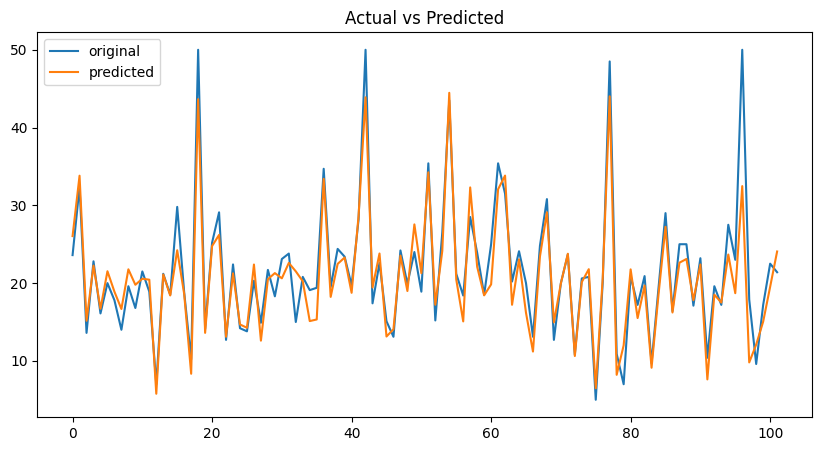

In [37]:
x_ax=range(len(y_test))
plt.figure(figsize=(10,5))
plt.plot(x_ax,y_test,label='original')
plt.plot(x_ax,y_pred,label='predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()